In [263]:
import numpy as np
import solar_sensor_env
import itertools
import functools
import pulp
import collections
def get_month(solarrecord, startmonth):
    startidx = startmonth*30*48
    finishidx = (startmonth+1)*30*48
    return solarrecord[startidx:finishidx]
import seaborn as sns

In [258]:
solarfname = 'training_12'
solarrecord = solar_sensor_env.get_generated_power(solarfname)
monthrecord = get_month(solarrecord,8)
#sanity check
print(sum(powerseries[0:8])/8, sum(monthrecord[0:48])/48)

0.4293984145236512 0.4293984145236512


In [202]:
def generate_all_dutycycle_plans(times = 8):
    possibilities = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    all_combs = itertools.product(possibilities, repeat=times)
    for comb in all_combs:
        yield comb
def calculate_consumed(duty_cycle):
    discharge_voltage = 3.7
    deltat = 3
    on_power = 56+45+15#mAh pyboard plus digimesh plus accel
    off_power = 45#mAh
    deepsleeppower = 0.5
    if duty_cycle >0:#sleeping
        used_power = (on_power*discharge_voltage*deltat*duty_cycle)+(off_power*discharge_voltage*deltat*(1-duty_cycle))
    else:#either pre-sleep or awake
        used_power = (deepsleeppower*deltat*discharge_voltage)
    return used_power
def evaluate_cost(harvest_prediction,aplan, deltat = 3):
    total_consumed = sum([calculate_consumed(duty) for duty in aplan]) #in MWh
    total_harvested = sum(harvest_prediction)*1000
    return np.abs(total_consumed - total_harvested)
    

min all i in day 
(duty_i*on_cost +(1-duty_i)*off_cost...(1-duty_n)*off_cost) - harvested
s.t.
0<duty_i<1

maximise the sum of duty cycle,
constrain such that the battery ending must be greater eq than the battery starting,
and no battery is less than zero

In [203]:
cost_evaluator = functools.partial(evaluate_cost, powerseries[0:8])

In [ ]:
plans= generate_all_dutycycle_plans()
min_cost_plan = min(((plan,cost_evaluator(plan)) for plan in plans), key=lambda i:i[1])

In [ ]:
min_cost_plan

In [253]:
def cost_calculator(deltat,dutycycle):
    discharge_voltage = 3.7
    on_power = 56+45+15#mAh pyboard plus digimesh plus accel
    off_power = 0.5
    used_power = (on_power*discharge_voltage*deltat*dutycycle)+(off_power*discharge_voltage*deltat*(1-dutycycle))
    return used_power
def generate_constraint(deltat,b0,harvested,duty_vars, t):
    #b1>0
    accumulated = [b0]+[-cost_calculator(deltat,duty_vars[i]) + 1000*deltat*harvested[i] for i in range(t)]
    return accumulated
    

In [ ]:
problem = pulp.LpProblem('ENO',pulp.LpMaximize)
deltat = 1
num_ts = int(24/deltat)
times = num_ts*28
duty_vars = pulp.LpVariable.dicts("D",[t for t in range(times)],0, 1,'Binary')
capacity = 2000*3.7 #mAh*3.7V
b_0= 0.3*capacity
problem+=pulp.lpSum(duty_vars)
day=0
powerseries = solar_sensor_env.downsample(monthrecord, factor=int(48/num_ts))
series = powerseries[day*num_ts:day*num_ts+times]
print(len(series),times)
#add constraints to ensure nonzero battery at all times
for i in range(1,times+1):
    b_i = generate_constraint(deltat,b_0,series, duty_vars, i)
    problem += (pulp.lpSum(b_i)>=0,'nonzero batt at t ={}'.format(i))
    #problem += (pulp.lpSum(b_i)<=capacity,'non max batt at t ={}'.format(i))
#add constraint to ensure energy positive operation
b_end = generate_constraint(deltat,b_0,series, duty_vars, times)
problem+=(pulp.lpSum(b_end)>=b_0,'battery at end must be greater than battery at start')

672 672


In [ ]:
problem.solve()

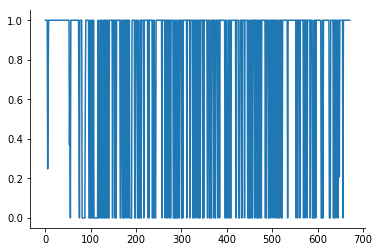

In [265]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1)
vals = sorted([v for v in problem.variables()], key=lambda i:int(i.name.split('_')[1]))
dseries = [v.varValue for v in vals]
ax.plot(dseries)
sns.despine()

In [266]:
import numpy as np
np.mean(dseries)

0.7295887613244048

In [ ]:
powerseire